# Objectives
- Create a python program utilizing Hugging Face ViT implementation to create vectors of the image
- Store these vectors in a Chroma DB vector database
- For a user query image, create a vector and retrieve to top 10 similar image vectors

In [40]:
# Hugging Face
from transformers import AutoImageProcessor, AutoModel
from datasets import load_dataset

# torch
import torch
from torchvision.io import read_image

#others

import chromadb
import math
import os
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import collections

In [41]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the Dataset API from HuggingFace

In [42]:
ds = load_dataset("fcakyon/pokemon-classification", name="full")
d_img= ds['train'][0] # first image
d_img

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/94604512981365-config-parquet-and-info-fcakyon-pokemon-classific-5a7ec0aa/downloads/extracted/bc050261dd5fc328e3d0cd4b7691b80c02abcc5a470596873ef1adfd683f07d5/Abra/0282b2f3a22745f1a436054ea15a0ae5_jpg.rf.8672478a3b97f7c0c5b6737c3fd2d3d8.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'labels': 80}

In [43]:
total_images=len(ds["train"])
total_images

4869

In [44]:
d_img["labels"]

80

### Observation
- Each entry in train split of this dataset is a dictionary object. It has following keys
    - image_file_path(no use for us)
    - image object (PIL object)
    - labels (indicating the class the image belongs to)
    

## Create a chroma persistent client to store these vectors.
id's will be the file names 

In [45]:
client = chromadb.PersistentClient(path=r"C:\Users\dsai9\Projects\VisionTransformer\VectorDB")


In [46]:
collection = client.get_or_create_collection(
    name="Vec_Pokemon",
    metadata={"hnsw:space": "cosine"} # l2 is the default
)

In [47]:
#client.delete_collection("Vec_Pokemon")

## Implement the function to vectorize images

In [48]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)

c:\Users\dsai9\Projects\VisionTransformer\ViT_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
def vectorize(image):
  inputs = processor(image, return_tensors="pt").to(DEVICE)
  outputs = model(**inputs)
  return outputs.pooler_output

In [18]:
image=d_img["image"]

In [19]:
vector = vectorize(image)


In [20]:
vector[0].size()

torch.Size([768])

In [21]:
# converting to list
type(vector[0].tolist())

list

### Create a pipeline to vectorize and store images in batches of 100 and also track their progress

In [22]:
def add_vectors(ds,label_to_images,limit_num=total_images+1):
    outer_loop_range = math.ceil(total_images / 100)
    
    for i in range(0, outer_loop_range):
        inner_loop_start = i * 100
        inner_loop_end = min((i * 100) + 100, total_images)
        
        # Inner loop with progress bar
        for j in tqdm(range(inner_loop_start, inner_loop_end), desc="Processing Images"):
            if limit_num == j:
                return
            
            try:
                d_image= ds["train"][j] #image dictionary
                #update the label_to_images dictionary
                label_to_images[d_image["labels"]]+=1
                
                image = d_image["image"]
                vector = vectorize(image)[0].tolist()
                collection.add(embeddings=[vector], ids=[str(j)])
            except Exception as e:
                print(e)
                print(f"At {j} unable to vectorize {e}")


In [23]:
# initialize a dictionary to get the images associated with each label for calculating recall
label_to_images = collections.defaultdict(int)

# Let's add first 100 images
add_vectors(ds,label_to_images,limit_num=100)

Processing Images:   0%|          | 0/100 [00:00<?, ?it/s]

Processing Images:   0%|          | 0/100 [00:00<?, ?it/s]


In [50]:
#client.delete_collection("Vec_Pokemon")

## Create a Function to query the Chroma DB and display query and top K retrieved images, and also calculate precision@K and recall@K
 

In [76]:
response=collection.query(
    query_embeddings=vectorize(ds["train"][2]["image"])[0].tolist(),n_results=10
)
response

{'ids': [['2', '12', '32', '49', '4', '26', '61', '63', '18', '69']],
 'distances': [[1.7881393432617188e-07,
   0.4023481607437134,
   0.4100421667098999,
   0.45351487398147583,
   0.4728381633758545,
   0.4865015149116516,
   0.48838746547698975,
   0.5343593955039978,
   0.5474588871002197,
   0.5493301749229431]],
 'metadatas': [[None, None, None, None, None, None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None, None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [77]:
candidate_ids=response["ids"][0]
candidate_ids

['2', '12', '32', '49', '4', '26', '61', '63', '18', '69']

Query Image
Candidate Image


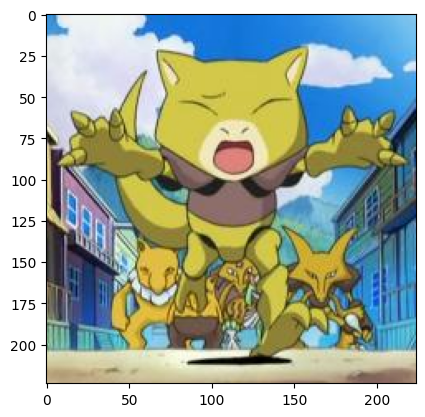

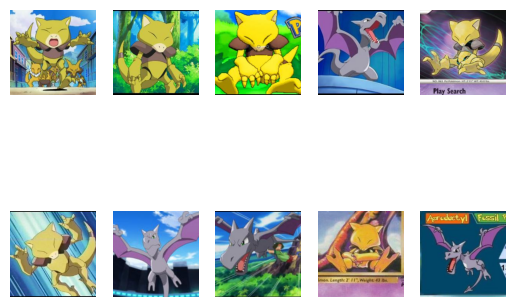

In [87]:
print("Query Image")
plt.imshow(ds["train"][2]["image"])    

# candidate images
print("Candidate Image")

fig,axs = plt.subplots(2,5)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(ds["train"][int(candidate_ids[i])]["image"])
    ax.axis('off')

In [60]:
def precision(k,label_to_images,candidate_labels,query_label):
    
    return candidate_labels[:k].count(query_label)/k

def recall(k,label_to_images,candidate_labels,query_label):
    
    return candidate_labels[:k].count(query_label)/label_to_images[query_label]


In [25]:
def getCandidates(query_id,k=30):
    response=collection.query(
        query_embeddings=vectorize(ds["train"][query_id]["image"])[0].tolist(),n_results=k
    )
    candidate_ids=response["ids"][0]
    return candidate_ids

In [61]:
def displayImages(candidate_ids,query_id):
    print("Query Image")
    plt.imshow(ds["train"][query_id]["image"])    

    # candidate images
    print("Candidate Image")

    fig,axs = plt.subplots(2,5)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(ds["train"][int(candidate_ids[i])]["image"])
        ax.axis('off')


In [62]:
# final function to evaluate the query

def evaluate(query_id,k=30):
    candidate_ids=getCandidates(query_id,k)
    print(candidate_ids)
    query_label = ds["train"][query_id]["labels"]
    candidate_labels = [ds["train"][int(i)]["labels"] for i in candidate_ids]
    displayImages(candidate_ids,query_id)
    for k in (10,20,30):
        print("Precision@{}: {}".format(k,precision(k,label_to_images,candidate_labels,query_label)))
        print("Recall@{}: {}".format(k,recall(k,label_to_images,candidate_labels,query_label)))

['2', '12', '32', '49', '4', '26', '61', '63', '18', '69', '51', '15', '7', '13', '25', '9', '27', '5', '35', '19', '3', '68', '0', '11', '21', '16', '89', '47', '76', '75']
Query Image
Candidate Image
Precision@10: 0.6
Recall@10: 0.17142857142857143
Precision@20: 0.7
Recall@20: 0.4
Precision@30: 0.6333333333333333
Recall@30: 0.5428571428571428


defaultdict(int, {80: 35, 119: 35, 99: 30, 2: 0})

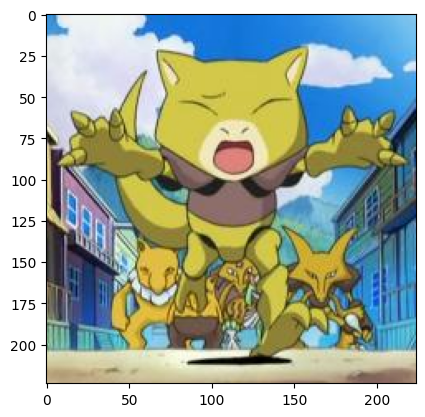

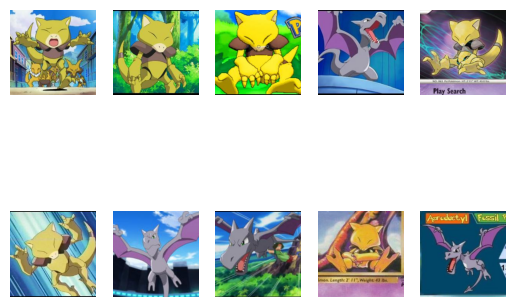

In [126]:
evaluate(2)
label_to_images

# DeiT


In [55]:
from transformers import AutoImageProcessor, DeiTModel,DeiTFeatureExtractor

image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224")
model = DeiTModel.from_pretrained("facebook/deit-base-distilled-patch16-224")



Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
from transformers import AutoImageProcessor, DeiTModel
def vectorize(image):
    
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    print(last_hidden_states.shape)
    return last_hidden_states

In [57]:
output=vectorize(ds["train"][2]["image"])

torch.Size([1, 198, 768])


In [34]:
class_token =output[0][0]
class_token.shape

torch.Size([768])

## Querying

torch.Size([1, 197, 768]) DEIT
['14', '75', '33', '28', '18', '11', '76', '12', '5', '27', '16', '32', '50', '7', '24', '69', '71', '25', '91', '4', '2', '72', '15', '21', '70', '3', '29', '85', '47', '67']
Query Image
Candidate Image
Precision@10: 0.8
Recall@10: 0.22857142857142856
Precision@20: 0.7
Recall@20: 0.4
Precision@30: 0.6333333333333333
Recall@30: 0.5428571428571428


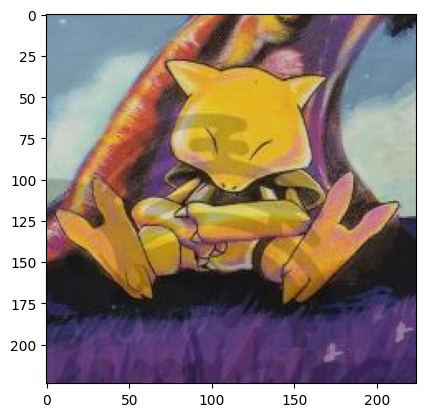

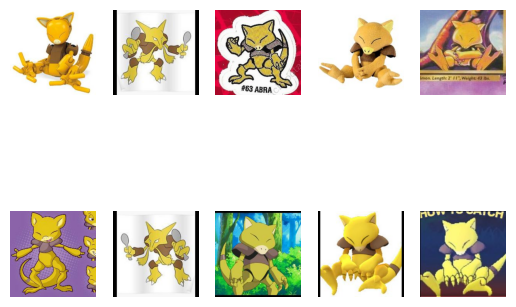

In [37]:
evaluate(1)

# BeiT

In [58]:
from transformers import AutoImageProcessor, BeitModel


image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k")



Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
def vectorize(image):
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    print(last_hidden_states.shape,"BEIT")
    return last_hidden_states

In [60]:
output=vectorize(ds["train"][0]["image"])
output.shape

torch.Size([1, 197, 768]) BEIT


torch.Size([1, 197, 768])

In [61]:
output[0][0].shape

torch.Size([768])

torch.Size([1, 197, 768]) BEIT
['7', '93', '17', '63', '79', '9', '94', '98', '14', '95', '56', '12', '84', '91', '70', '15', '2', '5', '73', '4', '26', '97', '28', '11', '16', '90', '35', '20', '69', '34']
Query Image
Candidate Image
Precision@10: 0.4
Recall@10: 0.11428571428571428
Precision@20: 0.45
Recall@20: 0.2571428571428571
Precision@30: 0.5
Recall@30: 0.42857142857142855


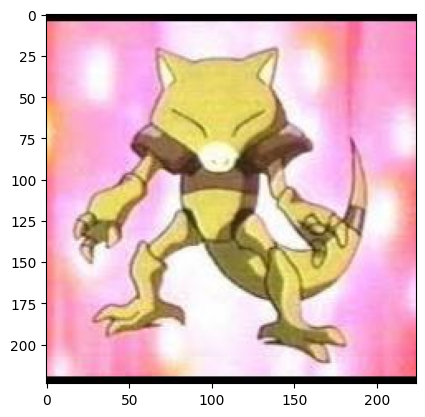

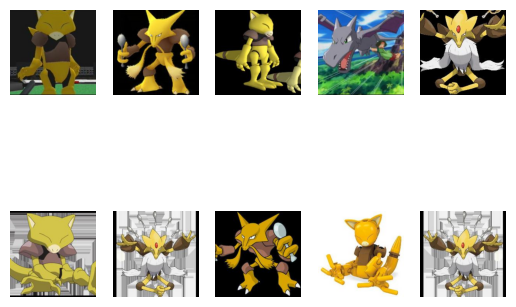

In [63]:
evaluate(0)

# SWIN

In [64]:
from transformers import AutoImageProcessor, SwinModel




image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

c:\Users\dsai9\Projects\VisionTransformer\ViT_env\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dsai9\.cache\huggingface\hub\models--microsoft--swin-tiny-patch4-window7-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [89]:
def vectorize(image):
    
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    print(last_hidden_states.shape,"SWIN")
    pooled_vector = last_hidden_states.mean(dim=1)
    print(pooled_vector.shape,"SWIN")
    return pooled_vector

In [92]:
output=vectorize(ds["train"][0]["image"])

torch.Size([1, 49, 768]) SWIN
torch.Size([1, 768]) SWIN


torch.Size([1, 49, 768]) SWIN
torch.Size([1, 768]) SWIN
['24', '14', '10', '85', '20', '73', '74', '72', '19', '86', '71', '87', '17', '5', '29', '30', '79', '31', '3', '8', '80', '81', '7', '83', '78', '82', '93', '91', '34', '89']
Query Image
Candidate Image
Precision@10: 0.5
Recall@10: 0.14285714285714285
Precision@20: 0.6
Recall@20: 0.34285714285714286
Precision@30: 0.4666666666666667
Recall@30: 0.4


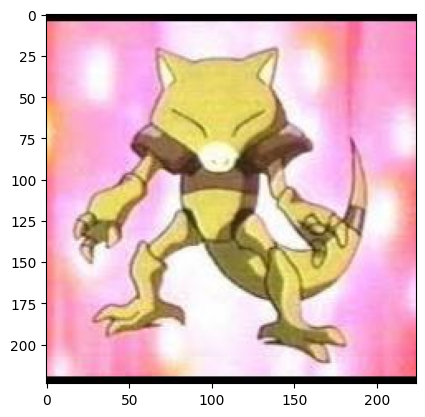

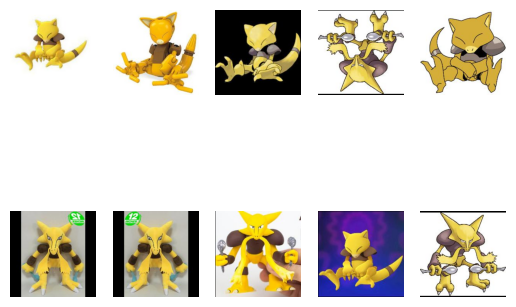

In [94]:
evaluate(0)

# Resnet 50


In [65]:
from transformers import AutoImageProcessor, ResNetModel


image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetModel.from_pretrained("microsoft/resnet-50")



In [66]:
def vectorize(image):
    
    inputs = image_processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)


    features = outputs.pooler_output.squeeze()
    #print(features.shape)
    return features

In [67]:
output=vectorize(ds["train"][0]["image"])
output

tensor([0.1060, 0.0331, 0.0343,  ..., 0.0000, 0.0470, 0.0041])

## Vectorizing 10 images


In [68]:
def add_vectors(ds,label_to_images,limit_num=total_images+1):
    outer_loop_range = math.ceil(total_images / 100)
    
    for i in range(0, outer_loop_range):
        inner_loop_start = i * 100
        inner_loop_end = min((i * 100) + 100, total_images)
        
        # Inner loop with progress bar
        for j in tqdm(range(inner_loop_start, inner_loop_end), desc="Processing Images"):
            if limit_num == j:
                return
            
            try:
                d_image= ds["train"][j] #image dictionary
                #update the label_to_images dictionary
                label_to_images[d_image["labels"]]+=1
                
                image = d_image["image"]
                vector = vectorize(image).tolist()
                collection.add(embeddings=[vector], ids=[str(j)])
            except Exception as e:
                print(e)
                print(f"At {j} unable to vectorize {e}")


In [69]:
label_to_images=collections.defaultdict(int)
add_vectors(ds,label_to_images,limit_num=40)

Insert of existing embedding ID: 0
Add of existing embedding ID: 0
Insert of existing embedding ID: 1
Add of existing embedding ID: 1
Insert of existing embedding ID: 2
Add of existing embedding ID: 2
Insert of existing embedding ID: 3
Add of existing embedding ID: 3
Insert of existing embedding ID: 4
Add of existing embedding ID: 4
Insert of existing embedding ID: 5
Add of existing embedding ID: 5
Insert of existing embedding ID: 6
Add of existing embedding ID: 6
Insert of existing embedding ID: 7
Add of existing embedding ID: 7
Insert of existing embedding ID: 8
Add of existing embedding ID: 8
Insert of existing embedding ID: 9
Add of existing embedding ID: 9
Insert of existing embedding ID: 10
Add of existing embedding ID: 10
Insert of existing embedding ID: 11
Add of existing embedding ID: 11
Insert of existing embedding ID: 12
Add of existing embedding ID: 12
Insert of existing embedding ID: 13
Add of existing embedding ID: 13
Insert of existing embedding ID: 14
Add of existing em

## evaluation

In [70]:
def getCandidates(query_id,k=30):
    response=collection.query(
        query_embeddings=vectorize(ds["train"][query_id]["image"]).tolist(),n_results=k
    )
    candidate_ids=response["ids"][0]
    return candidate_ids

['0', '16', '25', '30', '22', '20', '33', '11', '10', '32', '2', '12', '1', '23', '15', '26', '31', '18', '4', '27', '35', '8', '19', '36', '9', '21', '13', '34', '24', '3']
Query Image
Candidate Image
Precision@10: 1.0
Recall@10: 0.2857142857142857
Precision@20: 1.0
Recall@20: 0.5714285714285714
Precision@30: 0.9333333333333333
Recall@30: 0.8


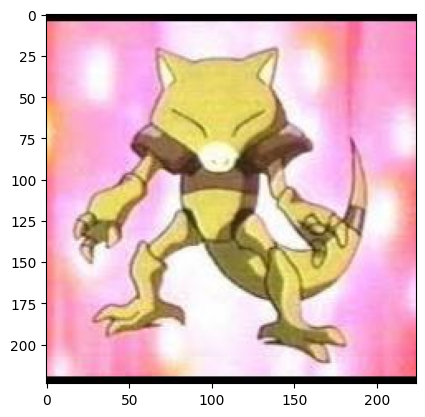

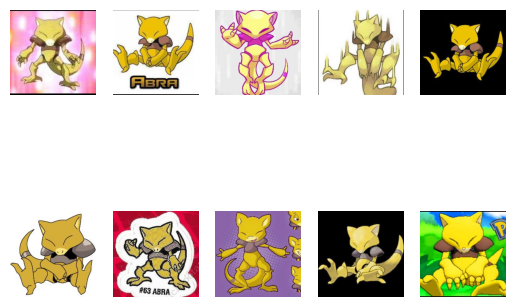

In [71]:
evaluate(0)